### Importing Libraries

In [1]:
import torch
from torch import nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
import pandas as pd
from PIL import Image
from sklearn.model_selection import train_test_split
import os
from tqdm.auto import tqdm


In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"

### Reading train.csv and Data Analysis

In [3]:
train_csv = pd.read_csv("train.csv") # Imported the csv file
print(train_csv.shape)
## Mappings for converting labels to integers and vice-versa
label_to_int_map = {
    'bright dune':0,
    'dark dune':1,
    'spider':2,
    'impact ejecta':3,
    'slope streak':4,
    'swiss cheese':5,
    'crater':6,
    'other':7
} 
int_to_label_map = {v:k for k, v in label_to_int_map.items()}

(6201, 2)


In [4]:
file_names, labels = train_csv['File Name'], train_csv['Class'] 
pd.set_option('future.no_silent_downcasting', True)
labels_int = labels.replace(label_to_int_map).to_list() #Converting labels from text to integers

new_file_names = []
for file_name in file_names:
    new_file_names.append(os.path.join('train_dataset', file_name)) ## file name with path


## Splitting files from train_dataset train and test splits
x_train, x_test, y_train, y_test = train_test_split(new_file_names, labels_int, test_size=0.2) 

## Train and Test dataframes containing file names and integer label columns
train_df = pd.concat([pd.Series(x_train), pd.Series(y_train)], axis=1)
test_df = pd.concat([pd.Series(x_test), pd.Series(y_test)], axis=1)



In [5]:
freq_df  = train_df[1].value_counts()
print(freq_df)

df0 = train_df[train_df[1] == 0].copy()
df1 = train_df[train_df[1] == 1].copy()
df2 = train_df[train_df[1] == 2].copy()
df3 = train_df[train_df[1] == 3].copy()
df4 = train_df[train_df[1] == 4].copy()
df5 = train_df[train_df[1] == 5].copy()
df6 = train_df[train_df[1] == 6].copy()
df7 = train_df[train_df[1] == 7].copy()


df0 = pd.concat([df0 for k in range(2)], ignore_index=True).sample(frac=1).reset_index(drop=True)
df1 = pd.concat([df1 for k in range(4)], ignore_index=True).sample(frac=1).reset_index(drop=True)
df2 = pd.concat([df2 for k in range(9)], ignore_index=True).sample(frac=1).reset_index(drop=True)
df3 = pd.concat([df3 for k in range(11)], ignore_index=True).sample(frac=1).reset_index(drop=True)
df4 = pd.concat([df4 for k in range(4)], ignore_index=True).sample(frac=1).reset_index(drop=True)
df5 = pd.concat([df5 for k in range(4)], ignore_index=True).sample(frac=1).reset_index(drop=True)
df6 = pd.concat([df6 for k in range(2)], ignore_index=True).sample(frac=1).reset_index(drop=True)
df7 = pd.concat([df7 for k in range(1)], ignore_index=True).sample(frac=1).reset_index(drop=True)


train_df_all = pd.concat([df0, df1, df2, df3, df4, df5, df6, df7], ignore_index=True).sample(frac=1).reset_index(drop=True)
print(train_df_all[1].value_counts())

noel = [600, 350, 300, 250, 600, 400, 1000, 1500]

train_df_1 = pd.concat([df0[:noel[0]], 
                         df1[:noel[1]], 
                         df2[:noel[2]], 
                         df3[:noel[3]], 
                         df4[:noel[4]], 
                         df5[:noel[5]], 
                         df6[:noel[6]], 
                         df7[:noel[7]]], ignore_index=True).sample(frac=1).reset_index(drop=True)

train_df_2 = pd.concat([df0[-noel[0]:], 
                         df1[-noel[1]:], 
                         df2[-noel[2]:], 
                         df3[-noel[3]:], 
                         df4[-noel[4]:], 
                         df5[-noel[5]:], 
                         df6[-noel[6]:], 
                         df7[-noel[7]:]], ignore_index=True).sample(frac=1).reset_index(drop=True)

train_df_1.shape, train_df_2.shape


1
7    2906
6     870
0     482
4     274
5     171
1     160
2      57
3      40
Name: count, dtype: int64
1
7    2906
6    1740
4    1096
0     964
5     684
1     640
2     513
3     440
Name: count, dtype: int64


((5000, 2), (5000, 2))

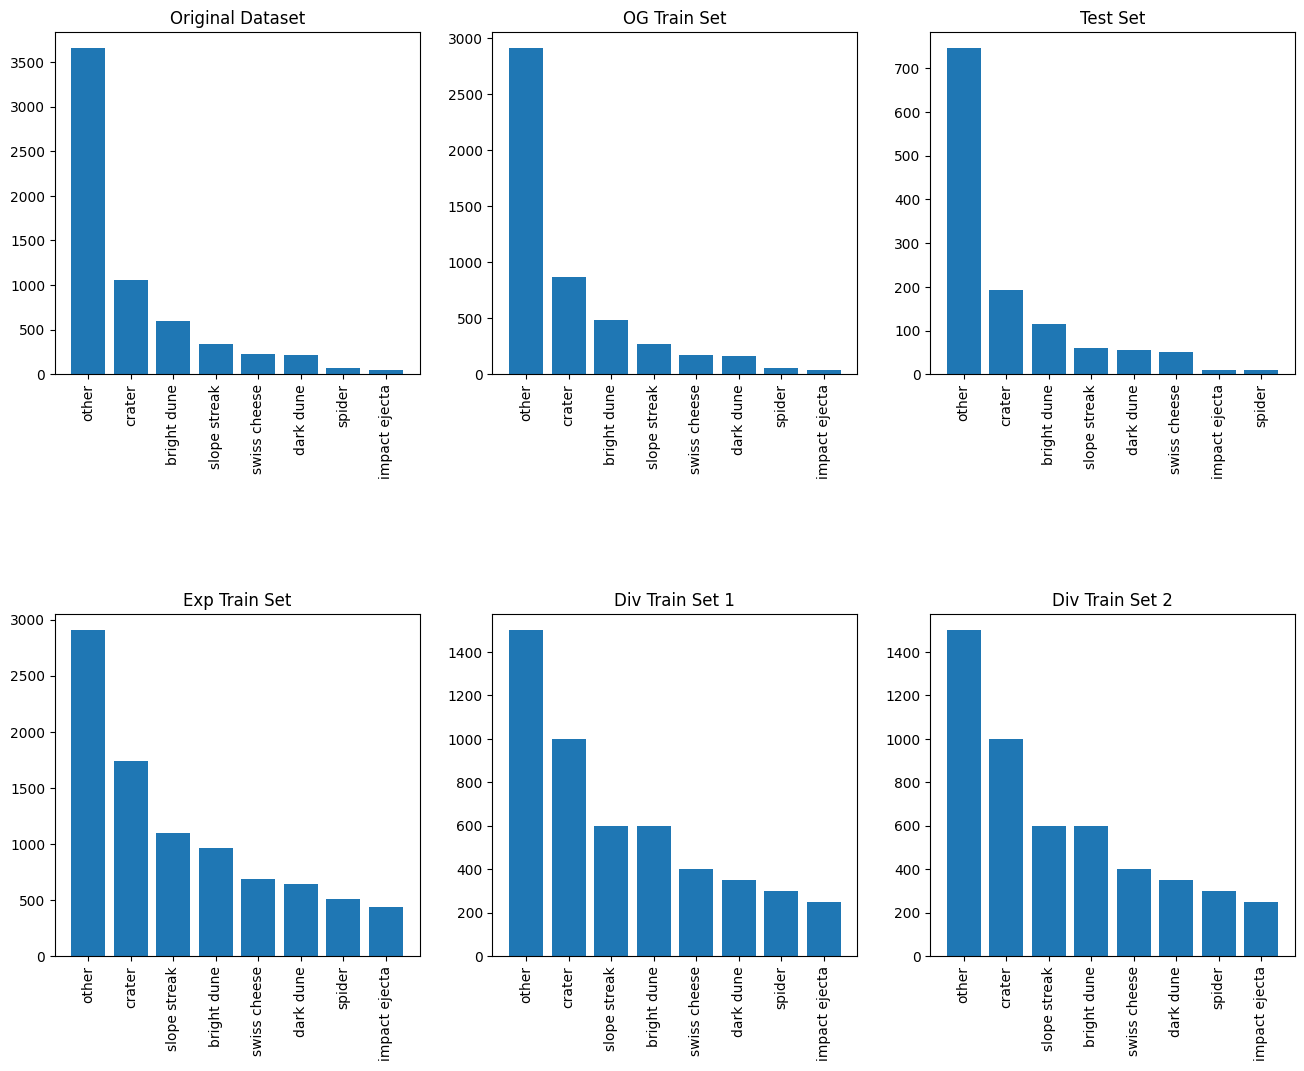

1
7    745
6    192
0    115
4     61
1     56
5     52
3     11
2      9
Name: count, dtype: int64 1241
8983
5000
5000


,0,1


In [6]:
## Plotting the frequencies of different types of images available in the dataset, and training-testing splits
freq = pd.Series(labels_int).value_counts()
freq_train = train_df[1].value_counts()
freq_train_all = train_df_all[1].value_counts()
freq_train_1 = train_df_1[1].value_counts()
freq_train_2 = train_df_2[1].value_counts()
freq_test = test_df[1].value_counts()

fig, ax = plt.subplots(2,3)

ax[0,0].bar([int_to_label_map[lab] for lab in freq.index ], freq)
ax[0,1].bar([int_to_label_map[lab] for lab in freq_train.index ], freq_train)
ax[0,2].bar([int_to_label_map[lab] for lab in freq_test.index ], freq_test)
ax[1,0].bar([int_to_label_map[lab] for lab in freq_train_all.index ], freq_train_all)
ax[1,1].bar([int_to_label_map[lab] for lab in freq_train_1.index ], freq_train_1)
ax[1,2].bar([int_to_label_map[lab] for lab in freq_train_2.index ], freq_train_2)

ax[0,0].tick_params('x', labelrotation = 90)
ax[0,1].tick_params('x', labelrotation = 90)
ax[0,2].tick_params('x', labelrotation = 90)
ax[1,0].tick_params('x', labelrotation = 90)
ax[1,1].tick_params('x', labelrotation = 90)
ax[1,2].tick_params('x', labelrotation = 90)

ax[0,0].set_title("Original Dataset")
ax[0,1].set_title("OG Train Set")
ax[0,2].set_title("Test Set")
ax[1,0].set_title("Exp Train Set")
ax[1,1].set_title("Div Train Set 1")
ax[1,2].set_title("Div Train Set 2")

fig.set_figwidth(16)
fig.set_figheight(12)
fig.subplots_adjust(hspace=0.7)

plt.show()

print(freq_test, freq_test.sum())
print(freq_train_all.sum())
print(freq_train_1.sum())
print(freq_train_2.sum())

pd.merge(train_df_all, test_df, how="inner")


### Importing the Images and creation of iterators for training
Images are imported as a PyTorch Dataset based on the filenames in the training and testing dataframes and the iterators are initiated

In [7]:
''' 
Creating a class that will take in the train/test filenames dataframe
as input and import and store images as a tuple: (image tensor, integer label)

'''
class MarsImgDataset(Dataset):
    def __init__(self, img_df, transform = None):
        super().__init__()
        self.frame = img_df
        self.transform = transform

    def __len__(self):
        return len(self.frame)
    
    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        img_name = self.frame.iloc[idx, 0]
        image = Image.open(img_name)

        if self.transform:
            image = self.transform(image)

        label = self.frame.iloc[idx, 1]
        sample = (image, label)
        
        return sample

In [22]:
IMAGE_SIZE = (224, 224) # Standardising the size for all images
data_transform = transforms.Compose([
    transforms.Resize(IMAGE_SIZE),
    transforms.ToTensor(),
    transforms.Normalize((0.5, ), (0.5, )),
    transforms.RandomHorizontalFlip(p = 0.6), # Random flips
    ])

train_dataset_1 = MarsImgDataset(train_df_1, data_transform)
train_dataset_2 = MarsImgDataset(train_df_2, data_transform)
test_dataset = MarsImgDataset(test_df, data_transform)

train_loader_1 = DataLoader(dataset=train_dataset_1, batch_size=32, shuffle=True) # Initialise Training Loader
train_loader_2 = DataLoader(dataset=train_dataset_2, batch_size=32) # Initialise Training Loader
test_loader = DataLoader(dataset=test_dataset, batch_size=32, shuffle=True) # Initialise Testing Loader

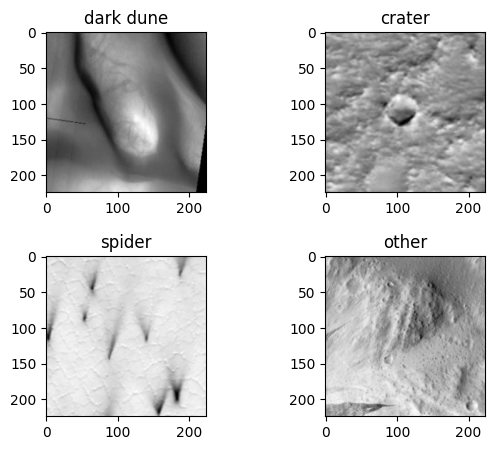

In [32]:
## Check the dataloaders by plotting the imported images
img, label = next(iter(train_loader_2))
figure, axis = plt.subplots(2,2)

axis[0,0].imshow(img[0].permute(1,2,0), cmap = 'Greys_r')
axis[0,0].set_title(int_to_label_map[label[0].item()])

axis[0,1].imshow(img[1].permute(1,2,0), cmap = 'Greys_r')
axis[0,1].set_title(int_to_label_map[label[1].item()])

axis[1,0].imshow(img[2].permute(1,2,0), cmap = 'Greys_r')
axis[1,0].set_title(int_to_label_map[label[2].item()])

axis[1,1].imshow(img[3].permute(1,2,0), cmap = 'Greys_r')
axis[1,1].set_title(int_to_label_map[label[3].item()])

plt.subplots_adjust(
    left=0.1, bottom=0.1, right=0.9, top=0.9, wspace=0.2, hspace=0.4
)

plt.show()
